# Week 6: Criticality & Cluster algorithms



The Markov Chain Monte Carlo (MCMC) algorithms we have seen so far have involved **local updates**. In the case of the Ising model, the proposed transitions were of the type of a single spin flip, while in the disk model a single disk was moved at each transition. The reason for choosing proposals that involve only local changes to the configuration should be clear: the closer the proposed state $y$ is to the current state $x$, the more likely the ratio $\pi(y)/\pi(x)$ is close to $1$, so decent acceptance rates can be maintained. A transition that flips many spins at once in the Ising model generically increases the energy by a large amount, so the Metropolis-Hastings acceptance probability would be microscopic. The downside of performing only local moves is that it requires many to change the state significantly. In other words **autocorrelation times** can be very large. This is something you have observed for the 2d Ising model in last week's exercises. In the low-temperature and high-temperature regimes the autocorrelation time is manageable and of the order of several sweeps. However, around $T = 2.2$ the autocorrelation time is seen to be much larger. 

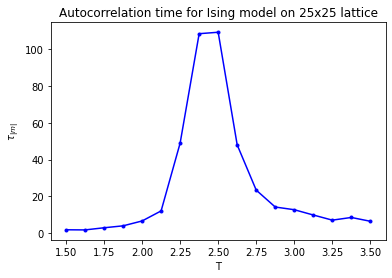

## Critical phenomena

As you may have noticed from your measurements of the magnetization, this is roughly where the transition occurs between the ordered and disordered phase of the ferromagnet. In fact, Onsager calculated the mean absolute magnetization per spin $\mathbb{E}{|m|}$ exactly in the limit of large lattices to be
$$\lim_{w\to\infty}\mathbb{E}[|m|] = \left( 1- [\sinh 2\beta J]^{-4}\right)^{\frac{1}{8}}.$$
Of course, this formula can only hold as long as $\sinh 2\beta J\geq 1$, i.e. $T\leq T_c$ where $T_c$ is the critical temperature
$$T_c = \frac{2J}{\log(1+\sqrt{2})} \approx 2.269 J.$$
For $T \geq T_c$ the magnetization vanishes, $\lim_{w\to\infty}\mathbb{E}[|m|] = 0$. Hence, the mean absolute-magnetization per site $\mathbb{E}[|m|]$ serves as an **order parameter** for the phase transition. 

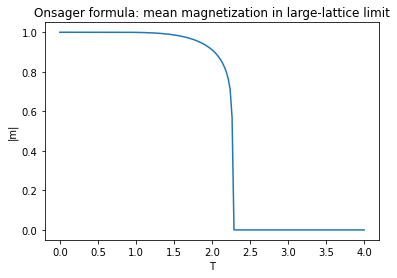

A phase transition like this where the order parameter is continuous through the phase transition is called a **continuous phase transition**. Such phase transitions have a severe impact on **correlation functions**, which in the case of the Ising model can be introduced as

$$C(\vec{r}) = \mathbb{E}[s_{\vec{x}}s_{\vec{x}+\vec{r}}] - \mathbb{E}[s_{\vec{x}}]\mathbb{E}[s_{\vec{x}+\vec{r}}], \qquad \vec{r},\vec{x}\in\mathbb{Z}^2.$$

Here $s_{\vec{x}}$ refers to the spin at site $\vec{x}\in\mathbb{Z}^2$. Note that because of translation symmetry $C(\vec{r})$ does not depend on $\vec{x}$. When $\vec{r}$ is large with respect to the lattice spacing and $T\neq T_c$, then we have that $C(\vec{r}) \sim c e^{-|\vec{r}|/\xi}$, where $\xi$ is the **correlation length**.
An important lesson from statistical physics is that continuous phase transitions give rise to **critical phenomena**: on an infinite lattice the correlation length $\xi$ diverges as the temperature $T$ approaches the critical temperature $T_c$,

$$ \xi \sim |T-T_c|^{-\nu}.$$

The quantity $\nu$ is called a **critical exponent**. Such quantities are of particular physical interest, because they do not depend on the precise parameters of the model or on the type of lattice (whether square or triangular for instance). The critical exponent $\nu$ is therefore called a **universal** property of the Ising model.  

When exactly at the critical temperature and on an infinite lattice, the correlation length of the Ising model is infinite, which manifests itself in the presence of spin clusters of every imaginable size. In fact, a feature of a statistical system at criticality is that it acquires a notion of **scale-invariance**. If one zooms out far enough, such that individual lattice sites are no longer visible, i.e. such that spin configuration has become continuous, then one can no longer tell the difference between one configuration and another that is zoomed out even further. This is nicely illustrated for the 2d Ising model in [this YouTube video](https://www.youtube.com/watch?v=fi-g2ET97W8). If you like, a quantity is universal if it is a property of this exactly scale-invariant regime. In general these scale-invariant models are described by [Conformal Field Theories](https://en.wikipedia.org/wiki/Conformal_field_theory).

One can also investigate the situation where one starts at a non-critical temperature, e.g. $T > T_c$, and zooms out while tuning the temperature towards criticality. More precisely, we can describe "zooming out" as assigning smaller and smaller physical edge length $a$ to the edges of the square lattice. If we scale the lattice spacing $a$ like $|T-T_c|^\nu$, then the physical correlation length $a\xi$ and the corresponding rescaled correlation function $C(\vec{x}/a)$ have well-defined limits. The result is a continuous spin system that is not scale-invariant, but possesses a non-vanishing finite correlation-length. 

The upshot of all this is that a lot of physics, in particular field theories, can be found at or close to critical points in discrete statistical systems. This is an important observation for Monte Carlo simulations, because we simply cannot simulate continuous fields with infinite degrees of freedom. One way or another fields have to be discretized before they can even be represented in a computer. If at all possible we would like our simulation results not to depend on the details of the chosen discretization, hence we would like to rely on the universality that can be found at critical points of the discretized system. 

## Critical slowing down

Of course, on a finite $w\times w$ lattice the correlation length cannot diverge and one cannot pinpoint an exact phase transition. But it is reasonable to assume that close enough to the critical temperature $T_c$ the spins at opposite ends of the lattice are non-negligibly correlated. This is something that can be seen by looking at individual configurations, like the following on a $100\times100$ lattice at a temperature below, close to, and above $T_c$.

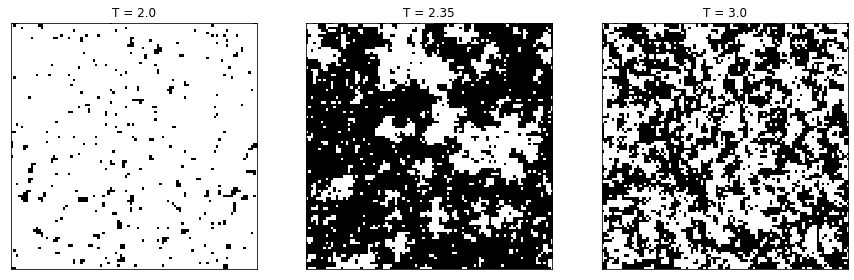

The critical correlation between far-away spins is disastrous for the autocorrelation time of the Metropolis-Hastings spin-flip Markov chain: a phenomenon known as **critical slowing down**. One can imagine that destroying spin clusters that extend over almost the whole lattice with only random single-spin flips is a time-consuming affair. This can be made quantitative by looking at the **dynamic exponent** $z$ of the spin-flip algorithm, which is defined as the exponent appearing in the relation between the autocorrelation time $\tau$ in units of sweeps and the temperature $T$ or correlation length $\xi$,
$$ \tau \sim |T-T_c|^{-z\nu} \sim \xi^z.$$
On a finite lattice we cannot have $\xi > w$, so close to criticality we expect $\tau \sim w^z$. Since the value of $z$ for the spin-flip is estimated at $z \approx 2.17$, the auto-correlation time at criticality increases very rapidly with the lattice size.

Critical slowing down is a serious obstacle in many MCMC simulations. Luckily the dynamic exponent $z$ is not a universal property of the statistical model at hand, but depends on the chosen MCMC algorithm. In some cases it is possible to find algorithms that have much smaller exponents. Cluster algorithms are a particularly well-known family of these.

## Cluster algorithm for the Ising model: the Wolff algorithm

We start by describing the transition algorithm and below we will investigate why it satisfies the detailed balance condition. Given a configuration $\mathbf{s} \in \{-1,1\}^N$ of the $w\times w$ Ising model. The next state $\mathbf{s}'$ in the Markov chain is obtained from $\mathbf{s}$ by flipping all spins in a random cluster $C$, i.e. $$s'_i = \begin{cases} -s_i & \text{if }i\in C \\ s_i & \text{if }i\notin C\end{cases}.$$ This cluster $C$ is constructed in an iterative manner starting with a cluster consisting of single "seed" site $i_{\text{seed}}$, which is uniformly chosen in the lattice. Let $\sigma = s_{i_{\text{seed}}}$ be its spin value. The goal is to grow the cluster by iteratively adding neighboring sites that have the same spin $\sigma$ with appropriate probability. More precisely, each site in the cluster is to be _visited_ once. Note that initially only the seed is there, so that is the first site to be visited, but later more sites will be added and the order in which they are then visited does not matter. Upon visiting a site each neighbor that is not yet part of the cluster is added to the cluster with independent probability $p_{\text{add}}$. The process stops when no more unvisited sites remain in the cluster. This resulting cluster is $C$, and to finish the Wolff transition we should flip each of the spins to $-\sigma$. Note that this is a **rejection-free algorithm** in the sense that $\mathbf{s}'$ is guaranteed to be different from $\mathbf{s}$.

When implementing this algorithm it is actually much more convenient to flip the spins directly at the moment they are added to the cluster. This way one does not have to keep track of the full cluster throughout the procedure, but only of the yet unvisited sites in the cluster. Since only neighbors are added that have spin $\sigma$, those are guaranteed to be not yet part of the cluster (visited or unvisited). The algorithm can therefore be implemented as follows. 

In [2]:
import numpy as np
rng = np.random.default_rng()  
import matplotlib.pylab as plt
%matplotlib inline

def aligned_init_config(width):
    '''Produce an all +1 configuration.'''
    return np.ones((width,width),dtype=int)

def plot_ising(config,ax,title):
    '''Plot the configuration.'''
    ax.matshow(config, vmin=-1, vmax=1, cmap=plt.cm.binary)
    ax.title.set_text(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

from collections import deque

def neighboring_sites(s,w):
    '''Return the coordinates of the 4 sites adjacent to s on an w*w lattice.'''
    return [((s[0]+1)%w,s[1]),((s[0]-1)%w,s[1]),(s[0],(s[1]+1)%w),(s[0],(s[1]-1)%w)]

def cluster_flip(state,seed,p_add):
    '''Perform a single Wolff cluster move with specified seed on the state with parameter p_add.'''
    w = len(state)
    spin = state[seed]
    state[seed] = -spin  
    cluster_size = 1
    unvisited = deque([seed])   # use a deque to efficiently track the unvisited cluster sites
    while unvisited:   # while unvisited sites remain
        site = unvisited.pop()  # take one and remove from the unvisited list
        for nbr in neighboring_sites(site,w):
            if state[nbr] == spin and rng.uniform() < p_add:
                state[nbr] = -spin
                unvisited.appendleft(nbr)
                cluster_size += 1
    return cluster_size

def wolff_cluster_move(state,p_add):
    '''Perform a single Wolff cluster move on the state with addition probability p_add.'''
    seed = tuple(rng.integers(0,len(state),2))
    return cluster_flip(state,seed,p_add)

Here is an illustration of the first 17 states in the corresponding Markov chain starting with the fully aligned state on a $40\times 40$ lattice at temperature $T = 2.4$.

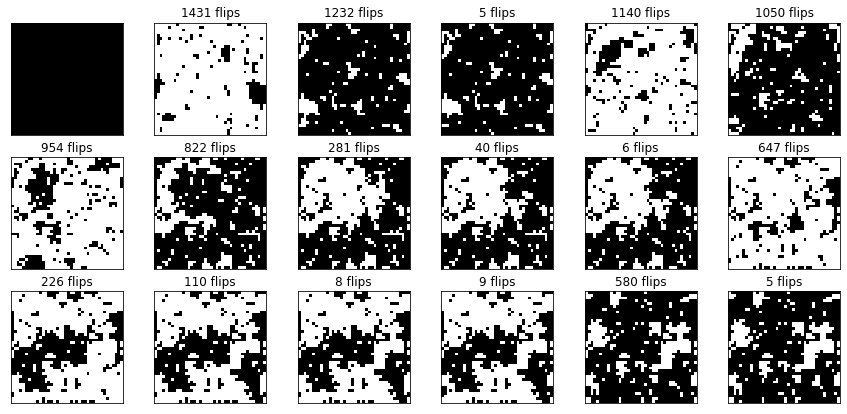

In [5]:
width = 40
temperature = 2.4
p_add = 1 - np.exp(-2/temperature)
config = aligned_init_config(width)
fig, axs = plt.subplots(3,6,figsize=(15,7))
flips = 0
for axrow in axs:
    for ax in axrow:
        plot_ising(config,ax,"{} flips".format(flips) if flips > 0 else "")
        flips = wolff_cluster_move(config,p_add)
        

It should be clear from the figures that the Markov chain explores the state space a lot quicker than the single-spin flip Markov chain does. This does not yet imply that it is significantly faster in cpu time, because a single Wolff move in which many spins are flipped of course takes proportionally more time than a single-spin flip. Note also that irrespective of the temperature there is a positive chance, at least $(1-p_{\text{add}})^4$, that a Wolff move only flips a single spin. It is therefore not so easy to reason about the efficiency or even judge what would be a "good" autocorrelation time (whether an autocorrelation time of, say, 100 is good depends a lot on whether the clusters mostly consist of only a few sites or comprise nearly the full lattice!). So we should also get an idea of the average size of clusters depending on temperature.

In [3]:
def compute_magnetization(config):
    '''Compute the magnetization M(s) of the state config.'''
    return np.sum(config)

def run_ising_wolff_mcmc(state,p_add,n):
    '''Run n Wolff moves on state and return total number of spins flipped.'''
    total = 0
    for _ in range(n):
        total += wolff_cluster_move(state,p_add)
    return total

def sample_autocovariance(x,tmax):
    '''Compute the autocorrelation of the time series x for t = 0,1,...,tmax-1.'''
    x_shifted = x - np.mean(x)
    return np.array([np.dot(x_shifted[:len(x)-t],x_shifted[t:])/len(x) for t in range(tmax)])

def find_correlation_time(autocov):
    '''Return the index of the first entry that is smaller than autocov[0]/e.'''
    goal = np.exp(-1)*autocov[0]
    for t in range(len(autocov)):
        if autocov[t] <= goal:
            return t
    # failed to find
    return len(autocov)

In [20]:
width = 20
nsites = width*width
temperatures = np.linspace(1.5,3.5,13)
equil_moves = 200
autocorr_moves = 1200
tmax = 70

autocorr_times = []

for temp in temperatures:
    p_add = 1 - np.exp(-2/temp)
    state = aligned_init_config(width)
    run_ising_wolff_mcmc(state,p_add,equil_moves)
    total_flips = 0
    trace = np.zeros(autocorr_moves)
    for i in range(autocorr_moves):
        total_flips += run_ising_wolff_mcmc(state,p_add,1)
        trace[i] = compute_magnetization(state)
    autocov = sample_autocovariance(np.abs(trace),tmax)
    time = find_correlation_time(autocov)
    autocorr_times.append((time,total_flips/(autocorr_moves)))

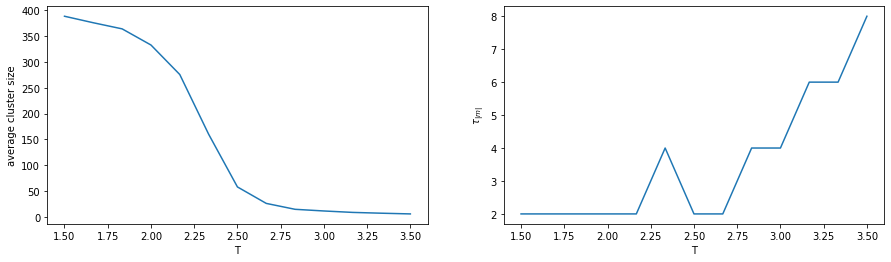

In [18]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].plot(temperatures,[av_size for tau,av_size in autocorr_times])
ax[0].set_xlabel("T")
ax[0].set_ylabel("average cluster size")
ax[1].plot(temperatures,[tau for tau,av_size in autocorr_times])
ax[1].set_xlabel("T")
ax[1].set_ylabel(r"$\tau_{|m|}$")
plt.show()

You should take the second plot with a pinch of salt. At low temperature the magnetization oscillates wildly because the typical cluster size is of the order of the full lattice, so the autocovariance function will not fit nicely to an exponential decay. The minimal possible value for $\tau_{|m|}$ in this case is $2$, meaning that no autocorrelation was detected. At higher temperature, more data is required to get an accurate estimate. Nevertheless a qualitative picture emerges: to decorrelate the magnetization measurements it suffices to perform a number of Wolff moves such that on average each site is flipped once. Put quantitatively, if $c(T)$ is the average cluster size in a Wolff move, then a **sweep** corresponds to performing roughly $N / c(T)$ moves. Only one or a few sweeps appear to be necessary to produce independent states, even close to the critical temperature!

Let us convince ourselves that the transition matrix $P(s \to s')$ of the Wolff algorithm satisfies the assumptions of last week's convergence theorem with limiting distribution $\pi(s) = \frac{1}{Z} e^{-\beta H(s)}$. Assuming positive temperature $T>0$, we have $0 < p_{\text{add}} < 1$. So the Wolff moves include the single-spin flips as possibilities, implying that $P(s \to s')$ is irreducible. The transition matrix does not include rejections, but is still aperiodic because it is possible to return to a state $s$ both in two and in three moves (e.g. via several single or double spin flips). It only remains to prove that $P$ satisfies detailed balance,
$$ \pi(s) P(s\to s') = \pi(s') P(s'\to s).$$
The plots below show an example of a transition $s\to s'$ as well as the inverse $s'\to s$. The green dots represent the seed and the cluster boundaries are drawn in red.

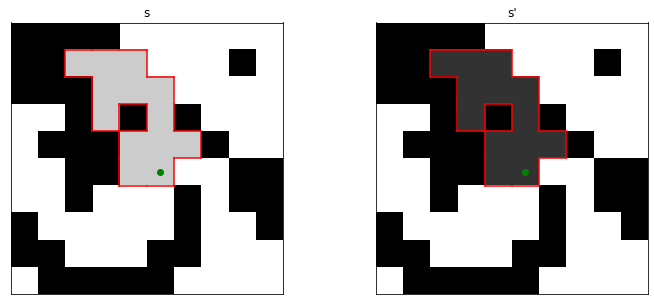

In [126]:
width = 10
temp = 2.7
p_add = 1 - np.exp(-2/temp)

# produce an equilibrated state
states = [aligned_init_config(width)]
run_ising_wolff_mcmc(states[0],p_add,100)
# perform wolff move on a copy with the seed nicely in the middle
states.append(np.copy(states[0]))
seed = (width//2,width//2)
cluster_flip(states[1],seed,p_add)

fig, ax = plt.subplots(1,2,figsize = (12,5))
diff = states[0]*states[1]
vert_boundary = np.nonzero(np.roll(diff,1,axis=1)-diff)
hor_boundary = np.nonzero(np.roll(diff,1,axis=0)-diff)
for i in range(2):
    plot_ising(0.8*states[i]+0.2*states[1-i],ax[i],["s","s'"][i])
    for y,x in np.transpose(vert_boundary):
        ax[i].plot([x-0.5,x-0.5],[y-0.5,y+0.5],'-r')
    for y,x in np.transpose(hor_boundary):
        ax[i].plot([x-0.5,x+0.5],[y-0.5,y-0.5],'-r')
    ax[i].scatter(*seed,color='green')
plt.show()

Note that the move $s\to s'$ is uniquely characterized by the cluster $C$, but there are many ways in which the cluster could have been constructed by the algorithm. Indeed, any of the sites in the cluster could have been the seed and the remaining sites in the cluster could have been added in many different orders. The important observation is that, given the cluster $C$, the set of such possibilities is exactly the same for the for $s\to s'$ and its inverse $s' \to s$. So if we can verify detailed balance for each particular construction of $C$, then detailed balance for the union of all constructions is guaranteed as well! We may thus assume that the seeds for both moves are chosen in the same place and that neighbors are explored in the same order. Where do the probabilities in the construction $s\to s'$ and $s'\to s$ differ? By construction, the spins within $C$ are all aligned, so the only difference occurs at the boundary of $C$. Let $m + n$ be the length of the boundary of $C$, where $m$ is the number of edges separating aligned sites and $n$ the number of edges separating anti-aligned sites. The probability of the cluster $C$ being selected in $s$ is proportional to $(1-p_{\text{add}})^m$, because for each of the $m$ edges there was an independent $1-p_{\text{add}}$ chance for the neighbor not to be added. Note that the cluster could not have been extended to anti-aligned sites, so the $n$ edges bordering those sites do not contribute to the probability. For the state $s'$ the roles of $m$ and $n$ are exactly interchanged, so there the probability is proportional to $(1-p_{\text{add}})^n$. Hence
$$\frac{P(s\to s')}{P(s'\to s)} = (1-p_{\text{add}})^{m-n}.$$
On the other hand, the energy difference between the two states is also determined entirely by $m$ and $n$, because the boundary is the only place where changes from aligned to anti-aligned occur (and vice versa). Examining the energy $H(s) = - J \sum_{i\sim j}s_i s_j$, we easily find
$$H(s') = H(s) + 2 J m - 2Jn,$$
implying that the ratio of the Boltzmann distribution is given by
$$\frac{\pi(s')}{\pi(s)} = e^{-\beta(H(s')-H(s)} = e^{-2\beta J (m-n)}.$$
Indeed, taking $p_{\text{add}} = 1-e^{-2\beta J}$ ensures detailed balance
$$\frac{P(s\to s')}{P(s'\to s)} = \frac{\pi(s')}{\pi(s)}.$$
This finishes the proof.

As a final remark, let me mention that there also exists a global version of the Wolff algorithm, known as the [Swendsen-Wang algorithm](https://en.wikipedia.org/wiki/Swendsen%E2%80%93Wang_algorithm). It is global in the sense that the full lattice is partitioned into clusters, instead of growing a single cluster, after which each cluster is flipped with an independent probability $1/2$.

## Cluster algorithm for the Disk Model

Also the disk model admits a cluster algorithm, in the sense that there exists a rejection-free algorithm that relies on selecting a cluster of disks, which is then collectively updated. In the case of the Ising model, the cluster algorithm crucially relied on the symmetry between $+1$ and $-1$ spins to ensure detailed balance. No analogous symmetry exists for individual disks, but one can take advantage of the translational and point-reflection symmetry of the disk model on the torus. Recall that in the disk model, the desired distribution is given by the probability density $\pi(\mathbf{x}) = 1/Z$ on the non-overlapping configurations $\mathbf{x}$. To ensure detailed balance we thus need a symmetric transition density $p(\mathbf{x},\mathbf{y}) = p(\mathbf{y},\mathbf{x})$. This is easily achieved by exploiting the symmetries of the torus, as was done in the exercises a while back by moving a single disk by a symmetrically distributed random displacement. The difficult part is to do this without rejection, i.e. to guarantee that the resulting configuration has no overlaps. One way to do this is via the following **geometric cluster algorithm**.

Suppose we have a non-overlapping configuration $\mathbf{x} = (x_1,\ldots,x_N) \in [0,L)^{2N}$ of $N$ disks on the $L \times L$ torus. A new configuration $\mathbf{y}$ is generated as follows. 
1. Sample a uniform point $p\in [0,L)^{2N}$ in the torus, called the "pivot".
2. Consider the configuration $\tilde{\mathbf{x}}\in [0,L)^{2N}$ obtained by point-reflecting all disks in the pivot, i.e. $\tilde{x}_i = 2p - x_i$ modulo $L$. 
3. Superimpose the disk configurations $\mathbf{x}$ and $\tilde{\mathbf{x}}$ and partition them into clusters of overlapping disks. Note that clusters may occur in pairs that are symmetric with respect to the pivot, but the partition $\{1,2,\ldots,N\} = c_1 \cup \cdots \cup c_k$ of the indices of the disks is unambiguous.
4. For each cluster $c_j$ independently with probability $1/2$ either leave all disks unmoved and set $y_i = x_i, \,i\in c_j$, or point-reflect all of them and set $y_i = \tilde{x}_i, i\in c_j$. 

It is not hard to convince yourself that the resulting configuration $\mathbf{y}$ is non-overlapping and that the transition density is symmetric $p(\mathbf{x},\mathbf{y}) = p(\mathbf{y},\mathbf{x})$. The algorithm is illustrated in the following simple example. Note that the pivot is drawn in green.

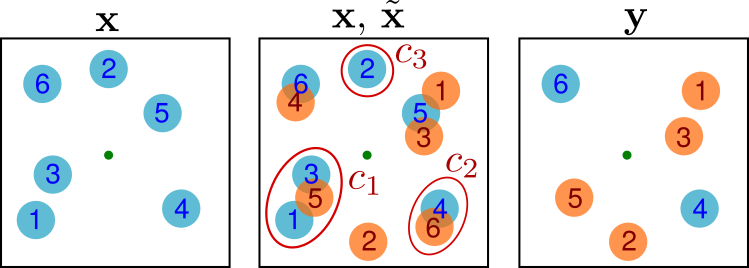

The geometric cluster algorithm as just described is a global cluster algorithm, like Swendsen-Wang for the Ising model. There is also a local cluster variant, that is easier to implement, the analogue of the Wolff algorithm. In this case a random initial disk is chosen as "seed" in addition to the random pivot, and only the cluster containing the seed is determined. Once the cluster has been found it is point-reflected in the pivot (without tossing a coin). The nice thing is that this can be implemented iteratively. First the seed disk is reflected. If it overlaps any other disks, those are also reflected. And this continues until no more overlaps occur, at which point the Markov chain transition is completed.

To do this efficiently we need a data structure that can quickly tell us what disks will have an overlap after the reflection. This can be achieved by partitioning the torus into a grid and tracking which sites are occupied by which disk, and maintaining this data in addition to the set of disk coordinates. Of course we should make sure that the grid spacing is small enough, e.g. one unit, such that any site can contain at most one disk. In the following we will assume that $L$ is an integer and use a regular integer grid for this purpose. The occupation is stored in an array with values ranging from $-1$ to $N-1$, where $-1$ means it is empty and $i\geq 0$ means that it contains the center of the disk with label $i$ (see `occupation_array`). To check for overlaps it suffices to examine the nearest and next-nearest neighbors in the grid (see `get_overlap`).

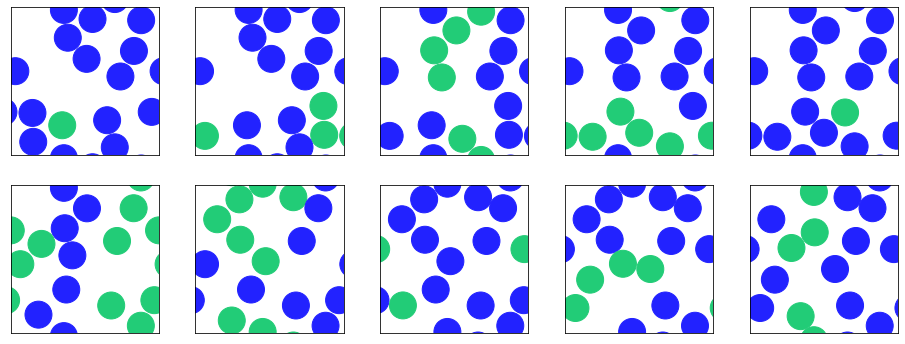

In [36]:
def plot_disk_configuration(positions,L,ax,color):
    '''Plot disk configuration. color is an array of bools specifying blue or green color.'''
    ax.set_aspect('equal')
    ax.set_ylim(0,L)
    ax.set_xlim(0,L)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    for i, x in enumerate(positions):
        # consider all horizontal and vertical copies that may be visible
        for x_shift in [z for z in x[0] + [-L,0,L] if -1<z<L+1]:
            for y_shift in [z for z in x[1] + [-L,0,L] if -1<z<L+1]:
                col = '#2222ff' if color[i] else '#22cc77'
                ax.add_patch(plt.Circle((x_shift,y_shift),1,color=col))

def occupation_array(l,pos):
    '''Return l*l array with indices of positions of disks in regular grid, -1 when empty.'''
    occupation = -np.ones((l,l),dtype='int')
    for i, (x, y) in enumerate(pos):
        occupation[int(x),int(y)] = i
    return occupation

def get_overlap(state,point):
    '''Return a list of indices of disks that have overlap with point.'''
    w = len(state["occ"])
    overlaps = []
    for dx in range(-2,3):
        x = (int(point[0]) + dx)%w
        for dy in range(-2,3):
            y = (int(point[1]) + dy)%w
            index = state["occ"][x,y]
            if index >= 0 and ( ((point[0]%1)-(state["x"][index,0]%1)-dx)**2 +
                                ((point[1]%1)-(state["x"][index,1]%1)-dy)**2 < 4):
                overlaps.append(index)
    return overlaps

def clear_disk(state,index):
    '''Remove disk from occupation array.'''
    state["occ"][int(state["x"][index,0]),int(state["x"][index,1])] = -1
def add_disk(state,index):
    '''Add disk to occupation array.'''
    state["occ"][int(state["x"][index,0]),int(state["x"][index,1])] = index

def point_reflect(pt,pivot,l):
    '''Reflect the point pt in the pivot (with periodic boundary conditions of length l).'''
    pt[:] = (2*pivot - pt)%l
    
def disk_cluster_move(state,index,pivot):
    '''Iteratively reflect disks in pivot, starting with index, until no more overlaps occur.'''
    movers = deque()
    movers.appendleft(index)
    clear_disk(state,index)
    while movers:
        mover = movers.pop()
        point_reflect(state["x"][mover],pivot,len(state["occ"]))
        overlap = get_overlap(state,state["x"][mover])
        for i in overlap:
            movers.appendleft(i)
            clear_disk(state,i)
        add_disk(state,mover)

def random_disk_cluster_move(state):
    '''Perform cluster move starting with random initial disk and uniform random pivot.'''
    index = rng.integers(0,len(state["x"]))
    pivot = rng.uniform(0,len(state["occ"]),2)
    disk_cluster_move(state,index,pivot)

side_length = 11
# arbitrary initial configuration
positions = np.array([[ 6.42852835,  9.34497979],
       [ 8.5774671 ,  5.5430735 ],
       [ 3.22720966,  8.0039044 ],
       [ 5.77002192,  4.57665577],
       [ 4.21675366,  2.92234618],
       [ 8.89704476,  2.66159969],
       [ 6.64404186,  7.03428799],
       [ 4.16896717,  6.16114986],
       [ 1.57600143,  6.5405559 ],
       [10.315628  ,  6.53294302],
       [ 0.21481807,  8.65080737],
       [ 7.04888305,  0.32190093],
       [10.93687882,  4.62709832],
       [ 2.3743327 ,  4.35629547]])

# describe the disk model state by the positions and occupation array
state = {"x": positions, "occ": occupation_array(side_length,positions)}
    
for _ in range(100):
    random_disk_cluster_move(state)
    
fig, axs = plt.subplots(2,5,figsize=(16,6))
previous_pos = np.copy(state["x"])
for axr in axs:
    for ax in axr:
        random_disk_cluster_move(state)
        color = (state["x"] == previous_pos).all(axis=1)
        plot_disk_configuration(state["x"],side_length,ax,color)
        previous_pos = np.copy(state["x"])
plt.show()

### Further reading

On the Ising model phase transition, critical slowing down, and cluster algorithms, see 3.7.1 - 4.3 of Newman & Barkema, _Monte Carlo Methods in Statistical Physics_, New York, USA (1999).

A gentle introduction to various cluster algorithms, including the Geometric cluster algorithm: https://csml.northwestern.edu/resources/Reprints/lnp_color.pdf